# Exploratory Analysis of Spatial Data: Spatial Autocorrelation #


In this notebook we introduce methods of _exploratory spatial data analysis_
that are intended to complement geovizualization through formal univariate and
multivariate statistical tests for spatial clustering.


## Imports

In [7]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import esda
import libpysal as lps
import contextily as cx

In [8]:
import seaborn as sns
sns.set_context('notebook')
%matplotlib inline

## Data

For this exercise, we'll use two datasets:

1. a set of polygons (census tracts) for the city of San Diego from the US Census American Community Survey 5-year estimates.

2. a set of points representing street trees in Surrey, BC. We will read in a CSV containing the necessary data and use the latitude and longitude attributes of the table to generate a `geopandas.GeoDataFrame`

### Census Polygons

In [9]:
scag = gpd.read_file("data/scag_region.gpkg")

In [10]:
san_diego = scag[scag.geoid.str[:5]=='06073'] # San Diego sliced out

In [11]:
san_diego.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 627 entries, 158 to 4567
Columns: 194 entries, geoid to geometry
dtypes: float64(172), geometry(1), int64(1), object(20)
memory usage: 955.2+ KB


In [12]:
san_diego = san_diego.dropna(subset=['median_home_value'])

In [13]:
san_diego = san_diego.to_crs(epsg=3857)

(-13099175.999157175,
 -12913655.05954583,
 3827188.049586128,
 3968975.9534278205)

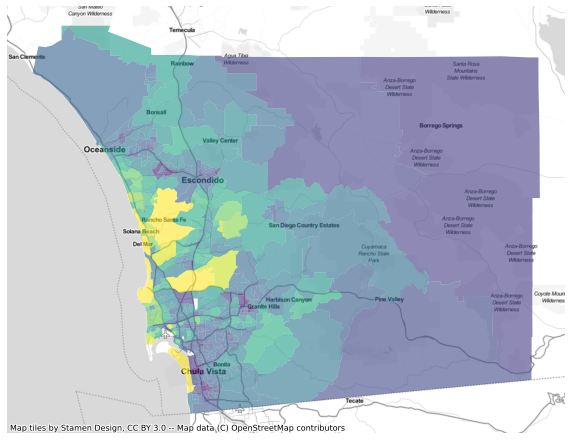

In [14]:
f, ax = plt.subplots(figsize=(10,10))

san_diego.plot('median_home_value', ax=ax, alpha=0.6)
cx.add_basemap(ax, crs=san_diego.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.axis('off')

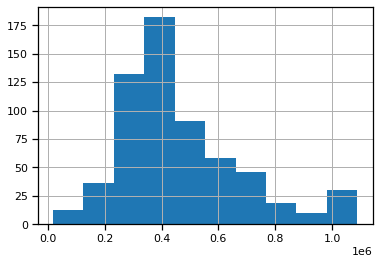

In [15]:
san_diego.median_home_value.hist()

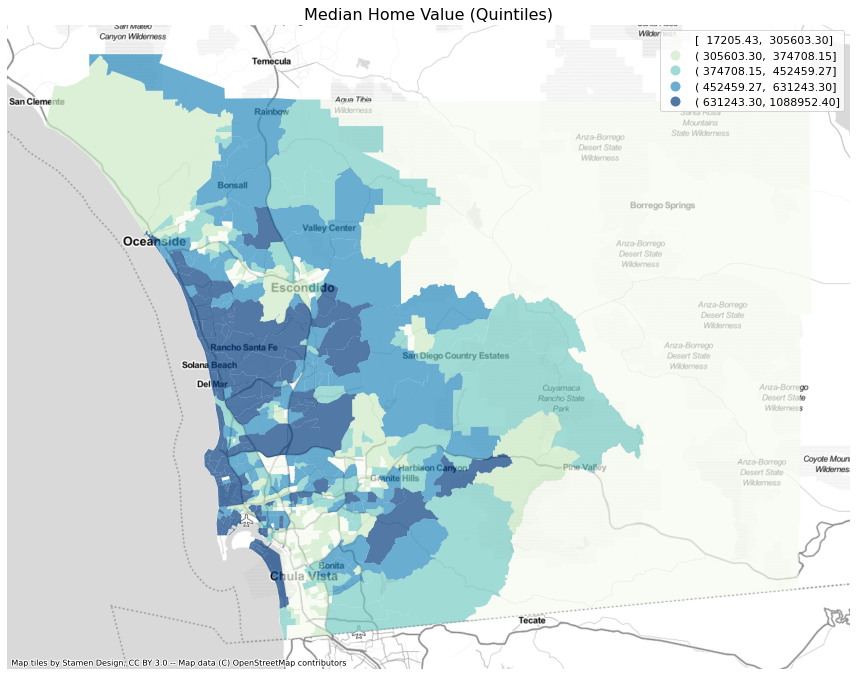

In [16]:
fig, ax = plt.subplots(figsize=(12,12))

san_diego.dropna(subset=['median_home_value']).to_crs(epsg=3857).plot('median_home_value', legend=True, scheme='quantiles', cmap='GnBu', k=5, ax=ax, alpha=0.7)

cx.add_basemap(ax, crs=san_diego.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.axis('off')

plt.title("Median Home Value (Quintiles)", fontsize=16)

plt.axis('off')
plt.tight_layout()

## Spatial Autocorrelation ##

Visual inspection of the map pattern for the prices allows us to search for
spatial structure. If the spatial distribution of the prices was random, then we
should not see any clustering of similar values on the map. However, our visual
system is drawn to the darker clusters along the coast,
and a concentration of the lighter hues (lower prices) in the north central and
south east. In the point data, the trees are too dense to make any sense of the pattern

Our brains are very powerful pattern recognition machines. However, sometimes
they can be too powerful and lead us to detect false positives, or patterns
where there are no statistical patterns. This is a particular concern when
dealing with visualization of irregular polygons of differning sizes and shapes.

The concept of *spatial
autocorrelation* relates to the combination of two types of similarity: spatial
similarity and attribute similarity. Although there are many different measures
of spatial autocorrelation, they all combine these two types of simmilarity into
a summary measure.

Let's use PySAL to generate these two types of similarity
measures.

### Spatial Similarity ###

We have already encountered spatial weights
in a previous notebook. In spatial autocorrelation analysis, the spatial weights
are used to formalize the notion of spatial similarity. As we have seen there
are many ways to define spatial weights, here we will use queen contiguity:

In [17]:
wq =  lps.weights.Queen.from_dataframe(san_diego)
wq.transform = 'r'

### Attribute Similarity ###

So the spatial weight between neighborhoods $i$ and $j$ indicates if the two 
are neighbors (i.e., geographically similar). What we also need is a measure of
attribute similarity to pair up with this concept of spatial similarity. The
**spatial lag** is a derived variable that accomplishes this for us. For neighborhood
$i$ the spatial lag is defined as: $$ylag_i = \sum_j w_{i,j} y_j$$

In [18]:
y = san_diego['median_home_value']
ylag = lps.weights.lag_spatial(wq, y)

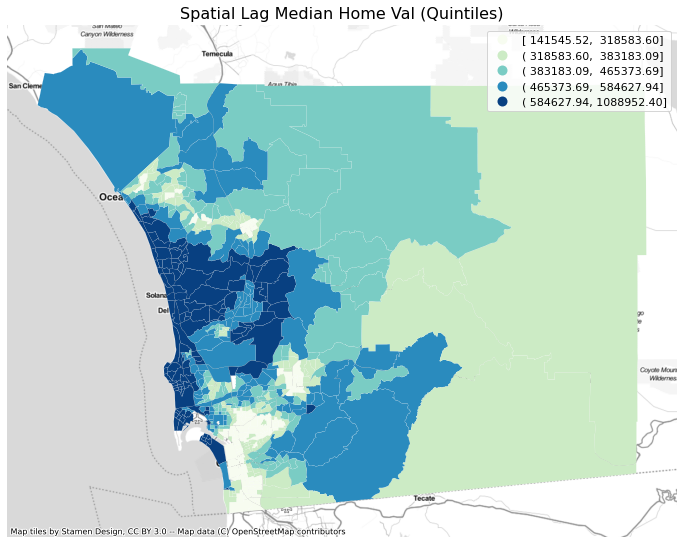

In [19]:
f, ax = plt.subplots(1, figsize=(12, 12))

san_diego.assign(cl=ylag).plot(column='cl', scheme='quantiles', \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

cx.add_basemap(ax, crs=san_diego.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.axis('off')

plt.title("Spatial Lag Median Home Val (Quintiles)", fontsize=16)

plt.show()

The quintile map for the spatial lag tends to enhance the impression of value
similarity in space. It is, in effect, a local smoother.

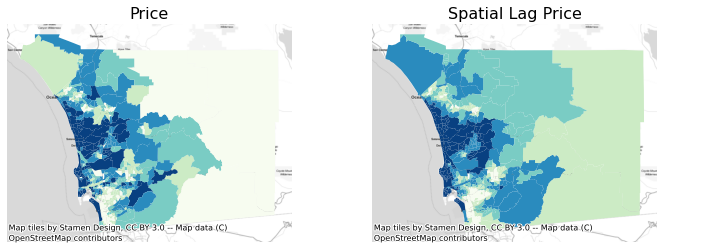

In [20]:
san_diego['lag_median_pri'] = ylag

f,ax = plt.subplots(1,2,figsize=(12,4))

san_diego.plot(column='median_home_value', ax=ax[0],
        scheme="quantiles",  k=5, cmap='GnBu')

#ax[0].axis(san_diego.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price", fontsize=16)

san_diego.plot(column='lag_median_pri', ax=ax[1],
        scheme='quantiles', cmap='GnBu', k=5)

cx.add_basemap(ax[0], crs=san_diego.crs.to_string(), source=cx.providers.Stamen.TonerLite)

cx.add_basemap(ax[1], crs=san_diego.crs.to_string(), source=cx.providers.Stamen.TonerLite)

ax[1].set_title("Spatial Lag Price", fontsize=16)
ax[0].axis('off')
ax[1].axis('off')

plt.show()

However, we still have
the challenge of visually associating the value of the prices in a neighborhod
with the value of the spatial lag of values for the focal unit. The latter is a
weighted average of home prices in the focal county's neighborhood.

To complement the geovisualization of these associations we can turn to formal
statistical measures of spatial autocorrelation.


## Global Spatial Autocorrelation



## Join counts ##

One way to formalize a test for spatial autocorrelation in a binary attribute is
to consider the so-called _joins_. A join exists for each neighbor pair of
observations, and the joins are reflected in our binary spatial weights object
`wq`. 

Each unit can take on one of two values "Black" or "White", and so for a given
pair of neighboring locations there are three different types of joins that can
arise:

- Black Black (BB)
- White White (WW)
- Black White (or White Black) (BW)


We can use the `esda` package from PySAL to carry out join count analysis. In the case of our point data, the join counts can help us determine whether different varieties of trees tend to grow together, spread randomly through space, or compete with one another for precious resources

### Polygon Data

With polygon data, we can conduct an analysis using a contiguity matrix. For our housing price data, we need to first discretize the variable we're using; to keep things simple, we'll binarize our price data using the median so that "high" values are tracts whose median home price is above the city's median and "low" values are those below

In [21]:
y.median()

403347.5655430712

In [22]:
san_diego.shape

(617, 195)

In [23]:
yb = y > y.median()
sum(yb)

308

In [24]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
san_diego['yb'] = yb

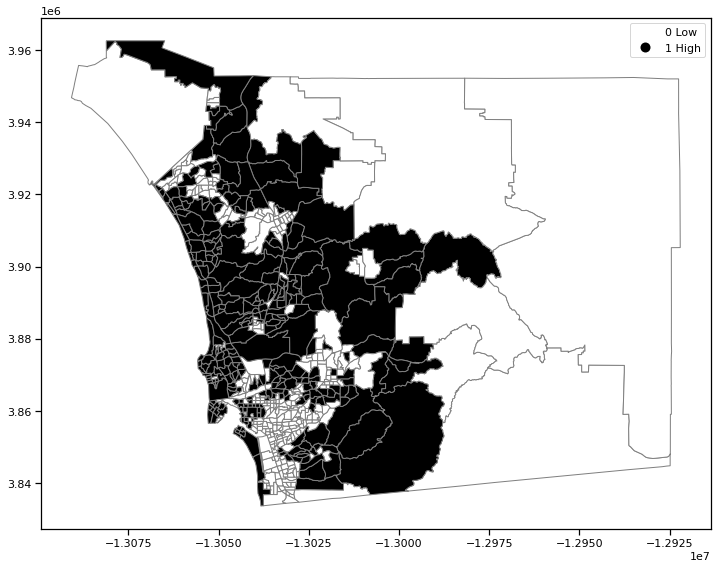

In [25]:
fig, ax = plt.subplots(figsize=(12,12))
san_diego.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

The spatial distribution of the binary variable immediately raises questions
about the juxtaposition of the "black" and "white" areas.

Given that we have 308 Black polygons on our map, what is the number of Black
Black (BB) joins we could expect if the process were such that the Black
polygons were randomly assigned on the map?

In [26]:
yb = 1 * (y > y.median()) # convert back to binary
wq =  lps.weights.Queen.from_dataframe(san_diego)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)

The resulting object stores the observed counts for the different types of joins:

In [27]:
jc.bb

736

In [28]:
jc.ww

724

In [29]:
jc.bw

467

Note that the three cases exhaust all possibilities:

In [30]:
jc.bb + jc.ww + jc.bw

1927

and

In [31]:
wq.s0 / 2

1927.0

which is the unique number of joins in the spatial weights object.

Our object tells us we have observed 736 BB joins:

In [32]:
jc.bb

736

The critical question for us, is whether this is a departure from what we would
expect if the process generating the spatial distribution of the Black polygons
were a completely random one? To answer this, PySAL uses random spatial
permutations of the observed attribute values to generate a realization under
the null of _complete spatial randomness_ (CSR). This is repeated a large number
of times (999 default) to construct a reference distribution to evaluate the
statistical significance of our observed counts.

The average number of BB joins from the synthetic realizations is:

In [33]:
jc.mean_bb

478

which is less than our observed count. The question is whether our observed
value is so different from the expectation that we would reject the null of CSR?

Text(0.5, 0, 'BB Counts')

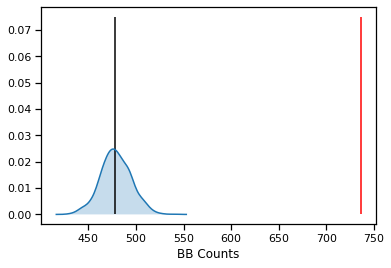

In [34]:
import seaborn as sbn
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')

The density portrays the distribution of the BB counts, with the black vertical
line indicating the mean BB count from the synthetic realizations and the red
line the observed BB count for our prices. Clearly our observed value is
extremely high. A pseudo p-value summarizes this:

In [35]:
jc.p_sim_bb

0.001

Since this is below conventional significance levels, we would reject the null
of complete spatial randomness in favor of spatial autocorrelation in market prices.


### Continuous Case

The join count analysis is based on a binary attribute, which can cover many
interesting empirical applications where one is interested in presence and
absence type phenomena. In our case, we artificially created the binary variable,
and in the process we throw away a lot of information in our originally
continuous attribute. Turning back to the original variable, we can explore
other tests for spatial autocorrelation for the continuous case.

First, we transform our weights to be row-standardized, from the current binary state:

In [36]:
wq.transform = 'r'

In [37]:
y = san_diego['median_home_value']

Moran's I is a test for global autocorrelation for a continuous attribute:

In [38]:
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.6798091424192116

Again, our value for the statistic needs to be interpreted against a reference
distribution under the null of CSR. PySAL uses a similar approach as we saw in
the join count analysis: random spatial permutations.

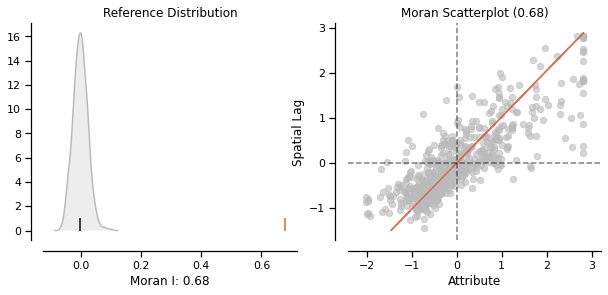

In [39]:
from splot.esda import plot_moran
plot_moran(mi, zstandard=True, figsize=(10,4))
plt.show()

On the left, we have the reference distribution versus the observed statistic; on the right, we have a plot of the focal value against its spatial lag, for which the Moran I statistic serves as the slope

Here our observed value is again in the upper tail

In [40]:
mi.p_sim

0.001

## Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers ##

In addition to the Global autocorrelation statistics, PySAL has many local
autocorrelation statistics. Let's compute a local Moran statistic for the same data

In [41]:
np.random.seed(12345)

In [42]:
wq.transform = 'r'
lag_price = lps.weights.lag_spatial(wq, san_diego['median_home_value'])

In [43]:
li = esda.moran.Moran_Local(y, wq)

Now, instead of a single $I$ statistic, we have an *array* of local $I_i$
statistics, stored in the `.Is` attribute, and p-values from the simulation are
in `p_sim`.

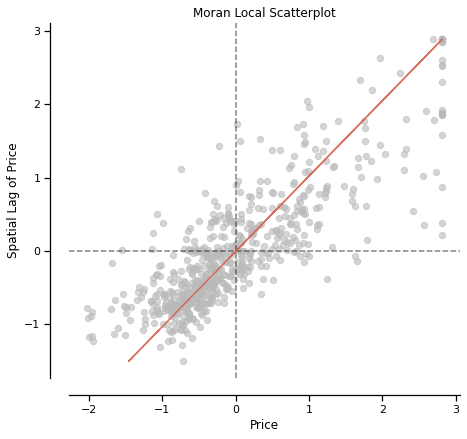

In [44]:
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(li)
ax.set_xlabel('Price')
ax.set_ylabel('Spatial Lag of Price')
plt.show()

In [45]:
li.q

array([4, 1, 2, 3, 3, 3, 3, 4, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 3, 2, 1, 1, 2, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 2, 1, 1, 1, 3,
       1, 3, 3, 4, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 2, 2,
       1, 2, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3,
       3, 2, 2, 2, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 2, 2,
       4, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3,
       3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3,
       3, 3, 3, 1, 1, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 3, 3, 2, 3, 4, 4, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 2, 1, 1, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 4, 1, 3, 3, 1, 4, 3, 3, 3, 3, 3, 3, 1, 3, 2, 2, 3, 3, 3,
       3, 3, 3, 1, 1, 1, 2, 4, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 1,
       1, 1, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 4, 1, 1, 1, 1, 3,
       1, 3, 4, 4, 4, 3, 2, 1, 1, 2, 3, 3, 2, 3, 4,

We can again test for local clustering using permutations, but here we use
conditional random permutations (different distributions for each focal location)

In [46]:
(li.p_sim < 0.05).sum()

241

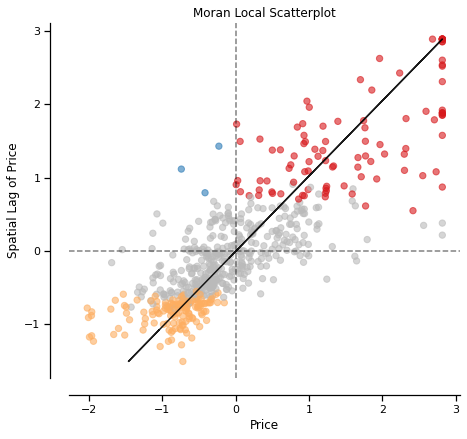

In [47]:
fig, ax = moran_scatterplot(li, p=0.05)
ax.set_xlabel('Price')
ax.set_ylabel('Spatial Lag of Price')
plt.show()

We can distinguish the specific type of local spatial association reflected in
the four quadrants of the Moran Scatterplot above:
- High-High (upper right)
- Low-Low (bottom left)
- High-Low (lower right)
- Low-High (upper left)

Using `splot`, we can also plot these hotspots on the original geodataframe

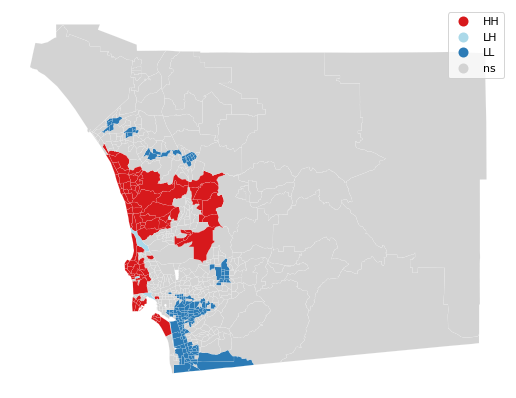

In [48]:
from splot.esda import lisa_cluster
lisa_cluster(li, san_diego, p=0.05, figsize = (9,9))
plt.show()

(<Figure size 1080x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f816b008910>,
       dtype=object))

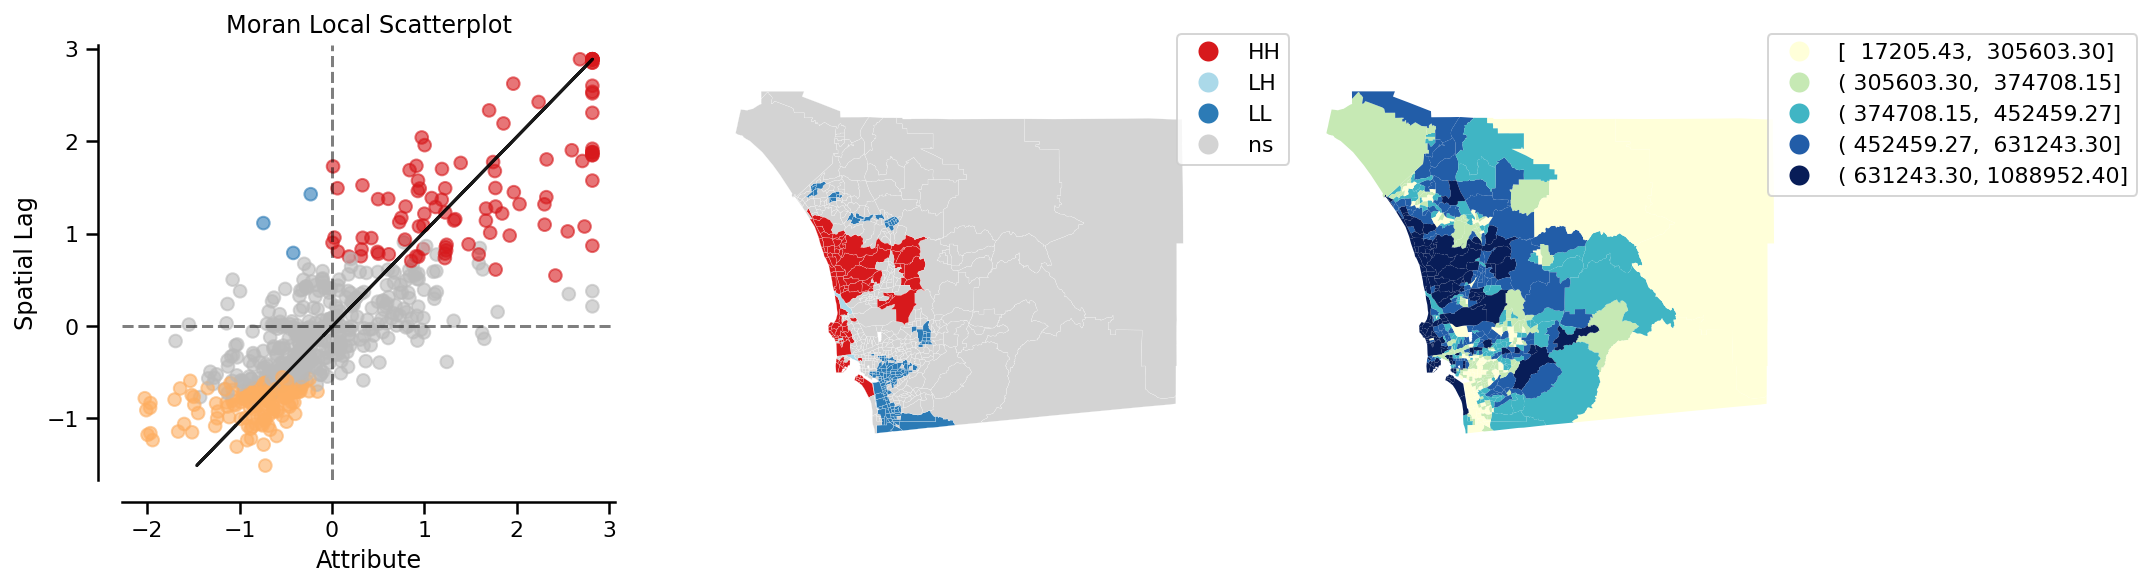

In [43]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(li, san_diego, 'median_home_value')

In [49]:
x=5
x


5

In [50]:
!python --version

Python 3.7.6
